In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from bokeh.io import output_notebook
output_notebook()
from bokeh.layouts import row, column, widgetbox
from bokeh.plotting import figure, output_notebook, output_file, show
from bokeh.models.sources import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.models import OpenURL, TapTool, CustomJS, Slider, Range1d, DatetimeTickFormatter
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from bokeh.charts import Histogram, Bar

import ml_insights as mli
pd.options.display.max_colwidth = 1000

Loading BokehJS ...

In [23]:
df = pd.read_csv('hypers.csv', index_col=0)
df['link'] = df.apply(lambda mo:'http://134.158.75.73:24000/pattern/out_of_class_figs.*{}.*'.format(mo['id']), axis=1)

model_names = [
    'model64', 
    'model101', 
    'model88', 
    'model55', 
    'gan']
output_cols = [
    'out_objectness', 
    'out_count', 
    'out_max',
    'in_objectness', 
    'in_count', 
    'in_max'
]
input_cols = list(set(df.columns) - set(output_cols))

# I you want to study a specific type of model, put its name
# in the variable 'model_name'. it should be a str among the 
# list 'model_names', which is defined above. Otherwise, if
# you want to study all the type of models at the same, set 
#'model_name' to None.
model_name = 'model64'
if model_name:
    df = df[df['model_name'] == model_name]
    df = df.dropna(axis=0, subset=output_cols)
    df = df.dropna(axis=1)

In [3]:
output_file('./www/models.html')

In [4]:
!ls www/

models.html


In [5]:
#royalblue, coral, seagreen, indianred, goldenrod, black, palevioletred

In [6]:
df['line_color'] = 'royalblue'
df['line_color'][df['model_name'] == 'model55'] = 'coral'
df['line_color'][df['model_name'] == 'model88'] = 'seagreen'
df['line_color'][df['model_name'] == 'model64'] = 'goldenrod'
df['line_color'][df['model_name'] == 'model101'] = 'palevioletred'
df['model_desc'] = 'gan'
df['model_desc'][df['model_name'] == 'model55'] = 'sparse conv'
df['model_desc'][df['model_name'] == 'model88'] = 'brushstroke'
df['model_desc'][df['model_name'] == 'model64'] = 'sparse fully connected'
df['model_desc'][df['model_name'] == 'model101'] = 'multi-scale sparse conv'

/home/ubuntu/miniconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ubuntu/miniconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ubuntu/miniconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/minico

In [7]:
hover = HoverTool(
        tooltips=[
            ("model", "@model_desc"),
        ]
    )

tools = [hover, 'pan,wheel_zoom,box_zoom,reset,previewsave,tap']
p = figure(
    plot_width=900, plot_height=900, tools=tools, title='',
)

p.circle(
    'out_objectness', 'out_count', size=10, line_color='line_color', fill_color='line_color',
    fill_alpha=0.9, line_width=1, source=ColumnDataSource(df), legend='model_desc'
)

p.xaxis.axis_label = 'out objectness'
p.yaxis.axis_label = 'out count'
p.xaxis.axis_label_text_font_size = '14pt'
p.yaxis.axis_label_text_font_size = '14pt'
p.legend.label_text_font_size = '14pt'
p.title.text_font_size = '16pt'
p.xaxis.major_label_text_font_size = '10pt'

url = "@link"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

In [22]:
df.sort_values(by='out_objectness', ascending=False).head()

KeyError: 'out_objectness'

## Feature importances

In [9]:
data = df.dropna(subset=output_cols, axis=0)
# shuffling data
ind = np.arange(len(data))
np.random.shuffle(ind)
data = data.iloc[ind]
data.head()

,autoencoding_loss,binarize_thresh,budget_hours,color,color_0,contractive,contractive_coef,dataset,denoise,eps,filter_size,id,k,k_0,k_1,k_2,k_3,k_4,l2,lr,marginalized,max_nb_epochs,merge_op,mode,model_name,n_steps,nb_fc_layers,nb_fc_units_0,nb_fc_units_1,nb_fc_units_2,nb_fc_units_3,nb_filters_0,nb_filters_1,nb_filters_2,nb_filters_3,nb_filters_4,nb_filters_mul,nb_hidden_units_0,nb_hidden_units_1,nb_hidden_units_2,nb_hidden_units_3,nb_hidden_units_4,nb_layers,nb_recurrent_layers,nb_recurrent_units_0,nb_recurrent_units_1,nb_recurrent_units_2,nbatch,ndf,ndfc,ngf,ngfc,niter,niter_decay,noise,nonlin,nonlin_out,normalize_func,nz,parallel,parallel_reduce_func,parallel_share,patch_index,patch_size,recurrent_model,reduce_func,scale,sparse_func,stride,use_wta_channel,use_wta_sparse,use_wta_spatial,walkback,walkback_mode,weight_sharing,wta_channel_stride,wta_sparse_perc,x_max,x_min,x_sigma,x_stride,y_max,y_min,y_sigma,y_stride,in_objectness,out_objectness,in_max,in_count,out_max,out_count,link,line_color,model_desc
1365,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05019cd37785c765c030a65313c76dba,3.0,NaN,NaN,NaN,NaN,NaN,0.000001,0.0002,NaN,NaN,NaN,NaN,gan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.0,128.0,256.0,64.0,64.0,50.0,100.0,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.319381,8.795822,0.982626,0.948518,0.340827,0.000000,http://134.158.75.73:24000/pattern/out_of_clas...,royalblue,gan
897,squared_error,NaN,6.0,NaN,NaN,False,NaN,digits,NaN,NaN,3.0,b0a0c31b1d0bb4d03c2cbe60133321ba,NaN,4.0,2.0,3.0,NaN,NaN,NaN,NaN,False,NaN,sum,random,model101,NaN,NaN,NaN,NaN,NaN,NaN,512.0,8.0,512.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wta_k_spatial,NaN,NaN,NaN,NaN,1.0,bengio_without_sampling,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.230603,4.554303,0.284647,0.000000,0.509783,0.170819,http://134.158.75.73:24000/pattern/out_of_clas...,palevioletred,multi-scale sparse conv
382,squared_error,NaN,6.0,predicted,NaN,False,NaN,digits,NaN,0.0,NaN,2407ef4a971b9725035326f6cd08af27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.000000e+10,NaN,random,model88,40.0,4.0,1900.0,800.0,600.0,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,200.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rectify,sigmoid,sigmoid,NaN,1.0,sum,False,0.0,4.0,lstm,sum,NaN,NaN,NaN,NaN,NaN,NaN,1.0,bengio_without_sampling,NaN,NaN,NaN,width,0.0,1,1.0,height,0.0,1,1.0,6.252194,6.315723,0.860253,0.798924,0.304422,0.179017,http://134.158.75.73:24000/pattern/out_of_clas...,seagreen,brushstroke
299,squared_error,NaN,6.0,predicted,NaN,False,NaN,digits,NaN,0.0,NaN,55e8b6caa34e695fe29b49ee93a1c9b8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.000000e+10,NaN,random,model88,74.0,1.0,1100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,500.0,100.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,very_leaky_rectify,sigmoid,sigmoid,NaN,1.0,sum,False,0.0,6.0,lstm,over,NaN,NaN,NaN,NaN,NaN,NaN,1.0,bengio_without_sampling,NaN,NaN,NaN,width,0.0,1,1.0,height,0.0,1,1.0,5.178365,7.802843,0.610745,0.386474,0.510355,0.273858,http://134.158.75.73:24000/pattern/out_of_clas...,seagreen,brushstroke
94,squared_error,0.5,6.0,NaN,NaN,False,NaN,digits,0.474747,NaN,3.0,6b3828e5a9497e031a120a03aaf9f24e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,model55,NaN,NaN,NaN,NaN,NaN,NaN,16.0,64.0,256.0,16.0,64.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,salt_and_pepper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True,1.0,bengio_without_sampling,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.344505,7.087915,0.569192,0.445984,0.579386,0.323326,http://134.158.75.73:24000/pattern/out_of_clas...,coral,sparse conv


In [10]:
x = data.drop(output_cols, axis=1)
x = pd.get_dummies(x)
x = x.fillna(-1)
y = data['out_objectness'] + 20 * data['out_count']

param_dist = {"max_depth": sp_randint(10, 100),
              "max_features": sp_randint(1, 10),
              "n_estimators": sp_randint(10, 100)}
n_iter_search = 30
reg = RandomizedSearchCV(
    RandomForestRegressor(), 
    n_jobs=-1,
    param_distributions=param_dist, 
    n_iter=n_iter_search, 
    scoring=make_scorer(r2_score),
    refit=True,
    cv=KFold(5).get_n_splits())
reg.fit(x, y)
print(reg.best_params_)
print(reg.best_score_)
best_reg = reg.best_estimator_

{'max_depth': 99, 'n_estimators': 85, 'max_features': 9}
0.359516051167


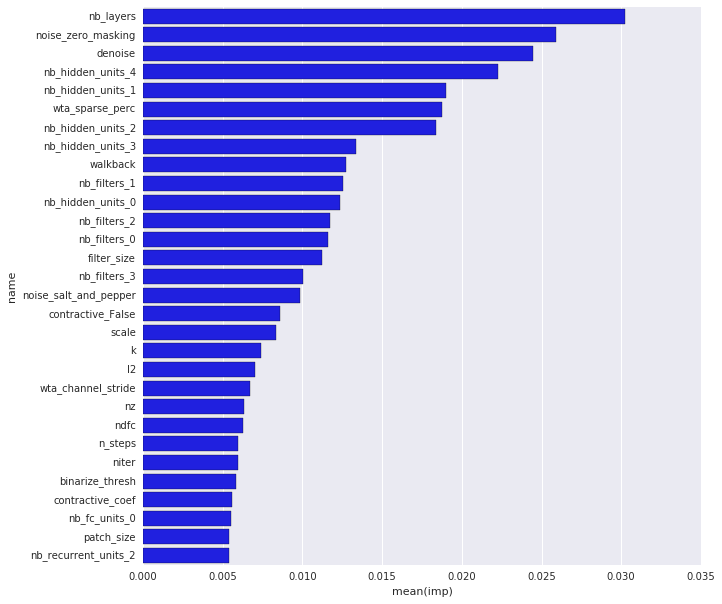

In [11]:
df = pd.DataFrame({'name': x.columns, 'imp': best_reg.feature_importances_})
df = df.sort_values(by='imp', ascending=False)
df = df.iloc[0:30]
fig = plt.figure(figsize=(10, 10))
sns.barplot(x='imp', y='name', data=df, color='blue', orient='h')
plt.show()

In [12]:
## ML insights is a package to understand supervised models
# check <https://github.com/numeristical/introspective> for more info
# e.g https://github.com/numeristical/introspective/blob/master/examples/Ames_Housing_Analysis.ipynb

In [ ]:
mxr = mli.ModelXRay(best_reg, x)

In [ ]:
mxr.feature_effect_summary?

In [ ]:
mxr.feature_effect_summary()

In [ ]:
mxr.feature_dependence_plots?

In [ ]:
mxr.feature_dependence_plots(num_pts=5)